1.1.1
Read the image edgetest_23.png

c:\Users\manos\anaconda3\envs\cv_lab1_env\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


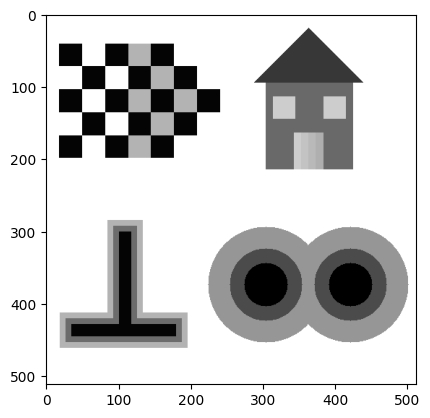

In [2]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

img= cv2.imread('edgetest_23.png', cv2.IMREAD_GRAYSCALE)
img = img.astype(np.float)/255
plt.imshow(img, cmap='gray' )


1.1.2
Add noise to the picture.

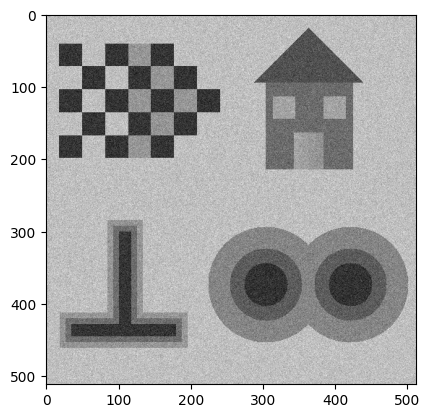

In [3]:
# i)


psnr = 20  
sigma = 0.1
mean=0

# Add the noise to the original image
noisy_img20 = np.random.normal(mean,sigma,img.shape)
noisy_img20 = noisy_img20.reshape(img.shape)
noisy_img20 = np.add(img, noisy_img20)

# Display the noisy image
plt.imshow(noisy_img20,cmap='gray')


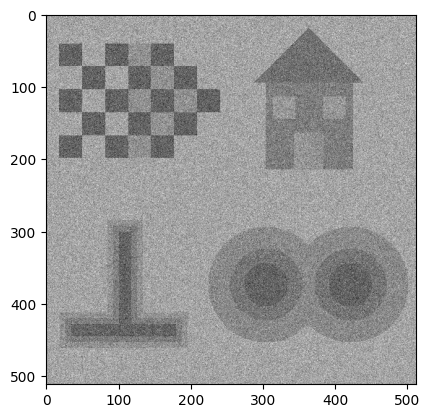

In [4]:
# i)

psnr = 10 
sigma = 0.316
mean=0

# Add the noise to the original image
noisy_img10 = np.random.normal(mean,sigma,img.shape)
noisy_img10 = noisy_img10.reshape(img.shape)
noisy_img10 = np.add(img, noisy_img10)

# Display the noisy image
plt.imshow(noisy_img10,cmap='gray')

1.2

Build a function named EdgeDetect following the steps below.

1.2.1
Build 2 filters

In [5]:
# 2D Gaussian

sigma=0.1

n= int(np.ceil(3*sigma)*2+1)

gauss1D = cv2.getGaussianKernel(n, sigma)
gauss2D = gauss1D @ gauss1D.T






In [6]:
#Laplacian of Gaussian

x = np.linspace(-n, n, 2*n+1)
y = np.linspace(-n, n, 2*n+1)

# Create 2D arrays for x and y coordinates using meshgrid
X, Y = np.meshgrid(x, y)

# Compute the LoG filter
LoG = -(X**2 + Y**2)/(2*sigma**2)
LoG = LoG / (2 * np.pi * sigma**4)
LoG = LoG * np.exp(-(X**2 + Y**2)/(2*sigma**2))

# Normalize the filter to have zero mean and unit variance
LoG = LoG - np.mean(LoG)
LoG = LoG / np.sqrt(np.sum(LoG**2))



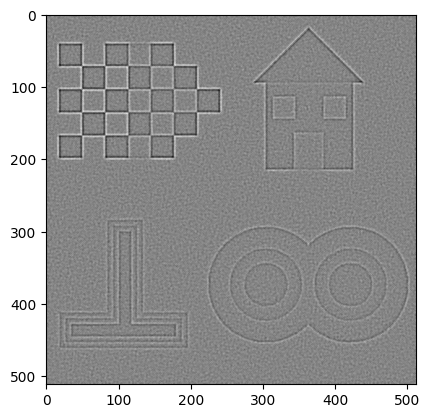

In [7]:
# L1 convolution LoG with img

filtered_img = cv2.filter2D(noisy_img20, -1, LoG)
plt.imshow(filtered_img, cmap='gray_r')

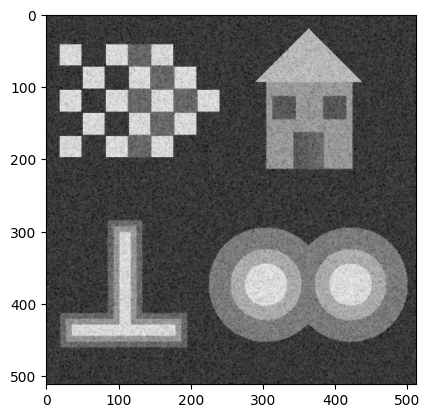

In [8]:
B = np.zeros((3,3), dtype=np.uint8)
B[1,:] = 1
B[:,1] = 1

Is= cv2.filter2D(noisy_img20,-1, gauss2D)

dilated= cv2.dilate(Is, B)
plt.imshow(dilated, cmap='gray_r')


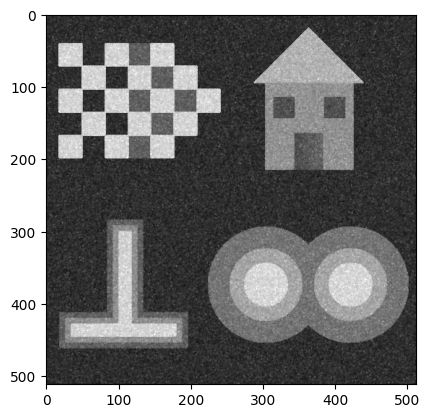

In [9]:
eroded=cv2.erode(Is,B)
plt.imshow(eroded, cmap='gray_r')

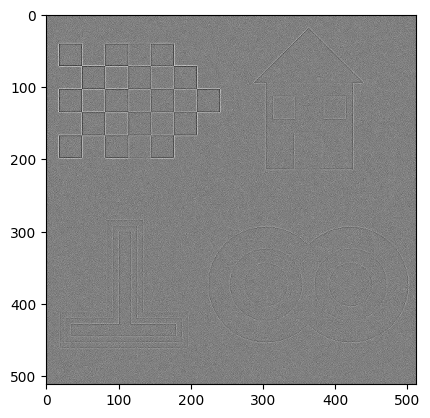

In [10]:
filtered_img2= dilated+eroded-2*Is
plt.imshow(filtered_img2, cmap = "gray_r")

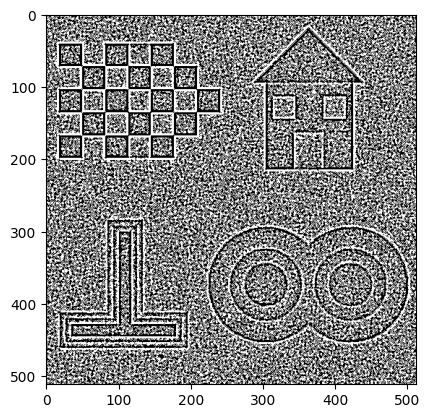

In [11]:
# Zero crossings

X= np.zeros(filtered_img.shape)
X[filtered_img>0]=1
X[filtered_img==0]=1

plt.imshow(X,cmap = "gray_r")


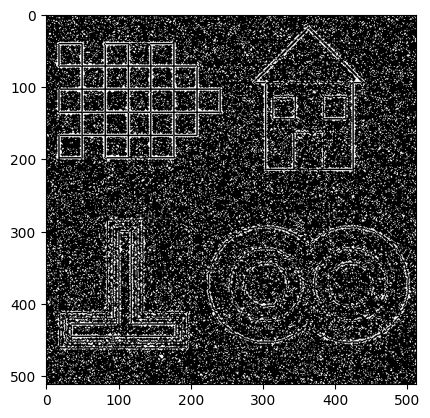

In [12]:
Y= cv2.dilate(X,B)-cv2.erode(X,B)
plt.imshow(Y,cmap = "gray_r")

Ολόκληρη η συνάρτηση.

In [13]:
def EdgeDetect (img, sigma, theta, type):

    # Kernel

    B = np.zeros((3,3), dtype=np.uint8)
    B[1,:] = 1
    B[:,1] = 1

    n= int (np.ceil (3*sigma)*2+1)

    # 2D Gaussian

    gauss1D = cv2.getGaussianKernel(n, sigma)
    gauss2D = gauss1D @ gauss1D.T

    # Laplacian of Gaussian

    x = np.linspace(-n, n, 2*n+1)
    y = np.linspace(-n, n, 2*n+1)

    # Create 2D arrays for x and y coordinates using meshgrid
    X, Y = np.meshgrid(x, y)

    LoG = -(X**2 + Y**2)/(2*sigma**2)
    LoG = LoG / (2 * np.pi * sigma**4)
    LoG = LoG * np.exp(-(X**2 + Y**2)/(2*sigma**2))

    LoG = LoG - np.mean(LoG)
    LoG = LoG / np.sqrt(np.sum(LoG**2))

    # Smoothed Image
    Is= cv2.filter2D(img, -1,gauss2D )

    # Check type of filter
    if (type == 'linear') :
        L= cv2.filter2D(img,-1,LoG)
    elif (type == 'nonlinear'):
        L=cv2.dilate(Is,B)+cv2.erode(Is,B)-2*Is
    else:
        raise ValueError("Invalid value for 'type': must be 'linear' or 'nonlinear'.")

    # Create the binary image
    X = np.zeros_like(L, dtype=np.uint8)
    X = np.where(L >= 0, 1, 0).astype(np.uint8)
    
    Y= cv2.dilate(X,B)-cv2.erode(X,B)

    grad_x, grad_y = np.gradient(Is, axis=(0, 1))


    grad_norm = np.sqrt(grad_x**2 + grad_y**2)

    # Threshold the gradient magnitude to reject zero crossings in gentle areas
    grad_mag_thresholded = np.where(grad_norm >= theta * np.max(grad_norm), grad_norm, 0)

    # Combine the zero crossings and gradient magnitude to get the final edge map
    result = np.where(Y == 1, grad_mag_thresholded, 0)

    return( result)





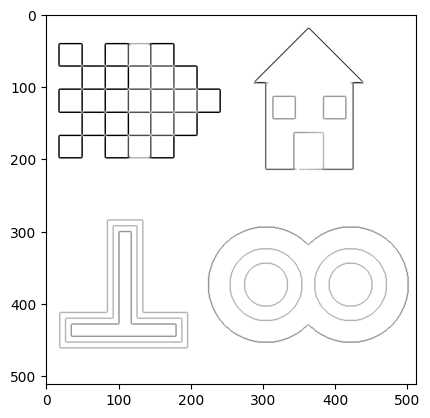

In [14]:
D = EdgeDetect(img, 1.5 ,0.2,'nonlinear')
plt.imshow(D, cmap='gray_r')

1.3. Αξιολόγηση των Αποτελεσμάτων Ανίχνευσης Ακμών

1.3.1 Υπολογισμός αληθινών ακμών

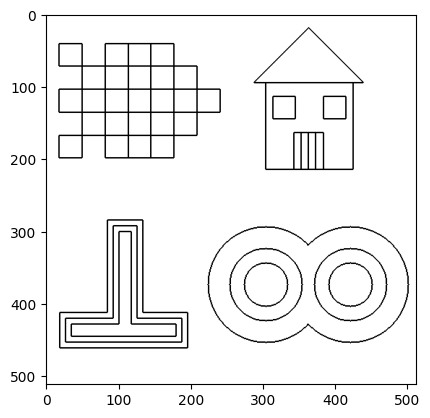

In [15]:
M = cv2.dilate(img, B) - cv2.erode( img, B)
T = (M > 0.01* np.max(M)).astype(np.uint8)

plt.imshow(T, cmap='gray_r')
plt.show()


1.3.2 Ποσοτική αξιολόγηση

In [16]:
def evaluation(D,T):

    # Calculate the intersection of D and T
    intersection = np.logical_and(D, T)

    # Calculate Precision and Recall
    precision = np.count_nonzero(intersection) / np.count_nonzero(D)
    recall = np.count_nonzero(intersection) / np.count_nonzero(T)

    # Calculate the quality criterion C
    C = (precision + recall) / 2

    return(C)


In [17]:
evaluation(D,T)

0.9772414049782467

1.4

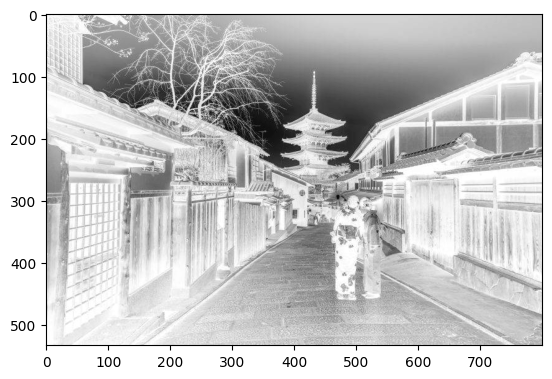

In [18]:
kyoto_img = cv2.imread('kyoto_edges.jpg', cv2.IMREAD_GRAYSCALE)
kyoto_img = kyoto_img.astype(np.float64)/255

plt.imshow(kyoto_img,cmap = "gray_r")


Βρίσκουμε τις πραγματικές ακμές του kyoto

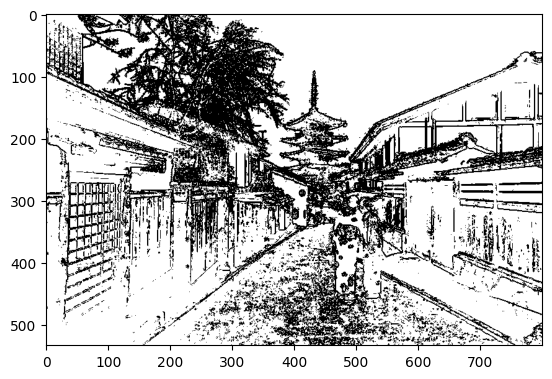

In [19]:
MK = cv2.dilate(kyoto_img, B) - cv2.erode( kyoto_img, B)
TK = (MK > 0.15* np.max(MK)).astype(np.uint8)/255

plt.imshow(TK, cmap='gray_r')
plt.show()

Συγκρίνουμε τα αποτελέσματα

0.8142682093046478

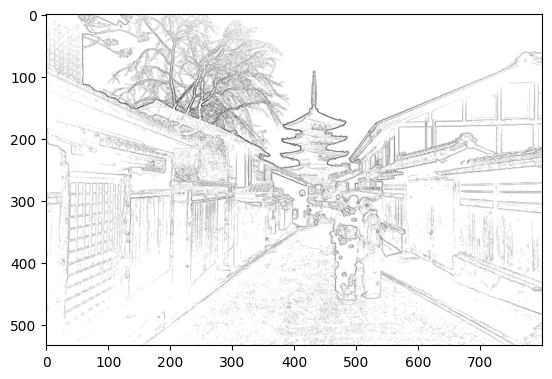

In [42]:
kyoto_edges= EdgeDetect(kyoto_img, 0.5, 0.1, 'nonlinear')

plt.imshow(kyoto_edges,cmap = "gray_r")

evaluation(kyoto_edges,TK)

<h4>1.4.2</h4> 

<h9>Χρησιμοποιούμε τον παρακάτω αλγόριθμο για να υπολογίσουμε τις καλύτερες επιλογές μας για τις τιμες των σ, θ προκειμένου να πετύχουμε όσο το δυνατόν καλύτερα αποτελέσματα. </h9>

In [25]:
best_evaluation = 0
best_sigma = None
best_theta = None

for sigma in np.arange(0.5, 3, 0.5):
    for theta in np.arange(0.1, 0.5, 0.1):
        D = EdgeDetect(kyoto_img, sigma, theta, 'nonlinear')
        evaluation_score = evaluation(kyoto_edges,TK)
        if evaluation_score > best_evaluation:
            best_evaluation = evaluation_score
            best_sigma = sigma
            best_theta = theta

print("Best sigma:", best_sigma)
print("Best theta:", best_theta)
print("Best evaluation:", best_evaluation)


Best sigma: 0.5
Best theta: 0.1
Best evaluation: 0.8142682093046478


<h9> Οι παραπανω τιμές είναι αυτές που μας δίνουν τα καλύτερα αποτελέσματα. Παρακάτω παρουσιάζουμε και κάποια άλλα ζεύγη τιμών και τα αποτελέσματα τους:
</h9>


<h10>
σ=4,θ=0.1: Αυξάνουμε το σ και παρατηρουμε ότι το evaluation έπεσε στα 0.38. Βλέπουμε ότι κάποια edges φάινονται πιο έντονα αλλά χάνουμε σημαντικές λεπτομέρειες
</10>

0.38875132982215743

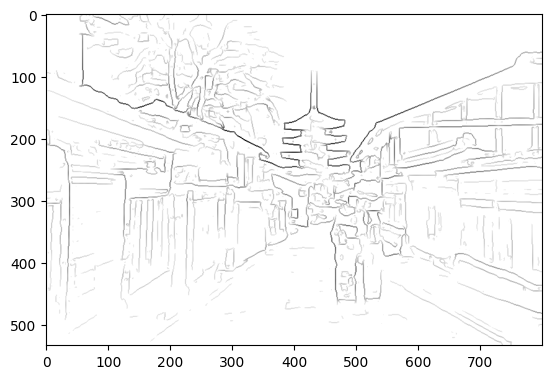

In [52]:
kyoto_edges= EdgeDetect(kyoto_img, 4, 0.1, 'nonlinear')

plt.imshow(kyoto_edges,cmap = "gray_r")

evaluation(kyoto_edges,TK)

<h10>
σ=0.5,θ=0.4: Αυξάνουμε το θ και παρατηρουμε ότι το evaluation έπεσε στα 0.52. Βλέπουμε κάποια edges αλλά χάνουμε πολλές λεπτομέρειες.
</10>

0.5295017250801367

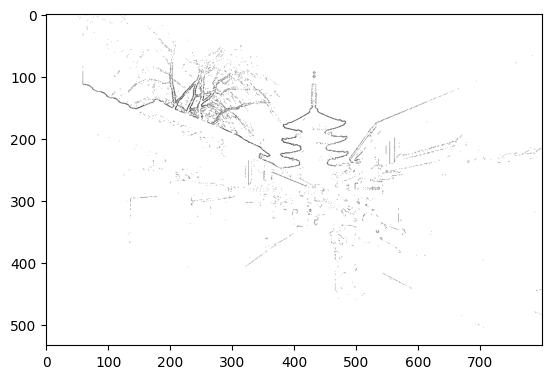

In [48]:
kyoto_edges= EdgeDetect(kyoto_img, 0.5, 0.4, 'nonlinear')

plt.imshow(kyoto_edges,cmap = "gray_r")

evaluation(kyoto_edges,TK)

<h10>
σ=0.5,θ=0: Μηδενίζουμε το θ και παρατηρουμε ότι το evaluation έπεσε στα 0.64. Βλέπουμε αρκετά edges αλλά με αυτές τις τιμές υπολογίζει και λανθασμένα edges.
</10>

0.6410870937371994

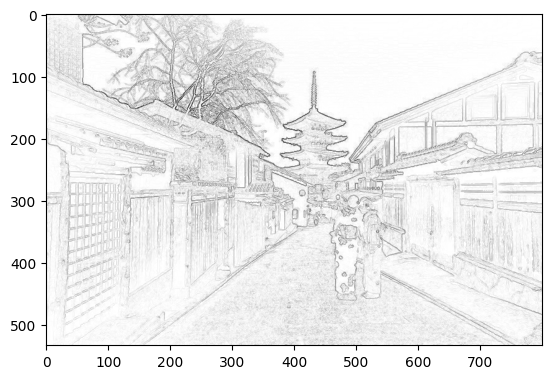

In [58]:
kyoto_edges= EdgeDetect(kyoto_img, 0.5, 0, 'nonlinear')

plt.imshow(kyoto_edges,cmap = "gray_r")

evaluation(kyoto_edges,TK)